<a href="https://colab.research.google.com/github/jackychencw/MIE1624_Course_Project_Group19/blob/Lawrence-nlp-preprocess/MIE1624_proj_LSTM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import tensorflow as tf
import pickle

from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Reshape
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import Adam

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin

from joblib import dump, load

from google.colab import drive

drive.mount('/content/drive')

data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/jacky_train_data.csv", index_col=0)
test_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/jacky_test_data.csv", index_col=0)
rating_pairs_path = "/content/drive/MyDrive/Colab Notebooks/data/rating_pairs.csv"
rating_pred_export_path = "/content/drive/MyDrive/Colab Notebooks/data/rating_pairs_pred.csv"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocess

In [2]:
def clean_data(data):
  data = data.drop(columns=[
                   'reviewerID', 'reviewText', 'unixReviewTime', 'itemID', 'reviewHash', 'important_features'])
  data['reviewTime'] = data.reviewTime.apply(lambda _: int(_[-4:]))
  dummy_years = pd.get_dummies(data.reviewTime, prefix='year')
  data = pd.concat([data, dummy_years], axis=1)
  data = data.drop(columns=['reviewTime'])
  return data

In [3]:
data = clean_data(data)
test_data = clean_data(test_data)


# Split training data into training set and validation set

In [4]:
saved_features = 2000 # max feature

y = data.overall
X = data.drop(columns=['overall'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
test_data = test_data.reindex(columns=X.columns)

# Neural Network model

We use a pipeline for our neural network model and it consists following steps: 

1.   The model uses column transformer to process the features separately. It normalizes the numeric features and vectorizes the text feature using TFIDF. We also use feature selection to select the best features for the text features.
2.   It transforms the sparse matrix produced by the column transformer to dense matrix in order to feed in the neural network.
3. The NN consists of a LSTM along with a few more dense layers and we use it to predict the overall rating.

In [6]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()
        
def create_model(num_layer=256, 
                 init_lr=0.005, 
                 decay_rate=0.95, 
                 decay_step=3000, 
                 drop_out=0.75,
                 epoch=50,
                 batch_size=64):
  def model_compiler(
      num_layer=num_layer,
      init_lr=init_lr,
      decay_rate=decay_rate,
      decay_steps=decay_step,
      drop_out=drop_out,
      loss_func='mse',
      metrics = [tf.keras.losses.MSE]
      ):
    model = tf.keras.Sequential([
      Reshape(target_shape=(1,-1)),
      LSTM(num_layer),
      Dropout(drop_out),
      Dense(num_layer*2, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(num_layer, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(num_layer/2, kernel_initializer='normal', activation='relu'),
      Dropout(drop_out),
      Dense(1, kernel_initializer='normal', activation='relu')
    ])
    # decay learning rate
    lr_schedule = ExponentialDecay(
        initial_learning_rate=init_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=True)

    opt = Adam(learning_rate=lr_schedule)
    model.compile(loss=loss_func, optimizer=opt, metrics=metrics)
    return model

  vectorizers = {
      'tfidf': TfidfVectorizer(),
      }
  summary_pipe = Pipeline([
                      ('vect', TfidfVectorizer()),
                      ('select', SelectKBest(chi2, k=saved_features))
                      ])

  review_pipe = Pipeline([('vect', TfidfVectorizer()),
                          ('select', SelectKBest(chi2, k=saved_features))
                                ])

  preprocess = ColumnTransformer([
                                ('price_std', StandardScaler(), ['price']),
                                ('summary_count_vec', summary_pipe, 'summary'),
                                ('review_tfidf', review_pipe, 'important_features(clean)')
                                ], remainder = 'passthrough')
  model = KerasRegressor(model_compiler, epochs=epoch, batch_size=batch_size, verbose=True)
  pipe = Pipeline([('preprocess', preprocess),
                    ('to_dense', DenseTransformer()),
                    ('nn', model)], verbose=True)
  return pipe



In [11]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
class ModelTuner():
  def __init__(self, params):
    self.params = params
    self.models = [create_model(**param, epoch=15) for param in self.params]
    self.train_scores = [0] * len(self.params)
    self.test_scores = [0] * len(self.params)

  def fit_scores(self, X_train, y_train, X_test, y_test):
    for i, model in enumerate(self.models):
      model.fit(X_train, y_train)
      y_train_pred = model.predict(X_train)
      y_pred = model.predict(X_test)
      self.test_scores[i] = mean_squared_error(y_test, y_pred)
      self.train_scores[i] = mean_squared_error(y_train, y_train_pred)
  
  def visualize(self, title, xlabel):
    width = 0.35  # the width of the bars
    x = np.arange(len(self.train_scores))
    params = [list(param.values())[0] for param in self.params]

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, self.train_scores, width, label='Train')
    rects2 = ax.bar(x + width/2, self.test_scores, width, label='Test')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(params)
    ax.set_xlabel(xlabel)
    ax.legend()

    plt.show()

    

Tune initial learning rate

In [19]:
lr_tuner = ModelTuner(params=[{'init_lr': 0.05},
                              {'init_lr': 0.01},
                              {'init_lr': 0.005}
                              ])
lr_tuner.fit_scores(X_train, y_train, X_test, y_test)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=   9.6s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.6s
Epoch 1/15
1875/1875 [==============================] - 9s 4ms/step - loss: 17.4449 - mean_squared_error: 17.4449
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 798.9627 - mean_squared_error: 798.9627
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 2641.8015 - mean_squared_error: 2641.8015
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 848.4644 - mean_squared_error: 848.4644
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 2222.5879 - mean_squared_error: 2222.5879
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 13.9881 - mean_squared_error: 13.9881
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 4.6323 - mean_squared_error: 4.6323
Epoch 8/15
1875/1875 [============================

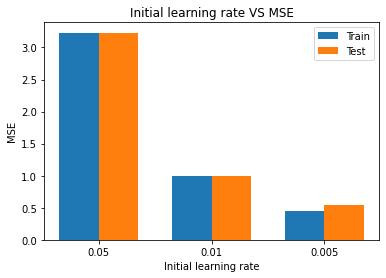

In [21]:
lr_tuner.visualize("Initial learning rate VS MSE", "Initial learning rate")

In [22]:
# Delete the model to free memory
del lr_tuner

Tune number of layers

In [23]:
layer_tuner = ModelTuner(params=[{'num_layer': 128},
                                 {'num_layer': 256},
                                 {'num_layer': 324}
                                ])
layer_tuner.fit_scores(X_train, y_train, X_test, y_test)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=   9.3s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.6s
Epoch 1/15
1875/1875 [==============================] - 9s 4ms/step - loss: 2.5170 - mean_squared_error: 2.5170
Epoch 2/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7089 - mean_squared_error: 0.7089
Epoch 3/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6423 - mean_squared_error: 0.6423
Epoch 4/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6219 - mean_squared_error: 0.6219
Epoch 5/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6056 - mean_squared_error: 0.6056
Epoch 6/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6050 - mean_squared_error: 0.6050
Epoch 7/15
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5858 - mean_squared_error: 0.5858
Epoch 8/15
1875/1875 [==============================] - 7s 4ms/step - loss

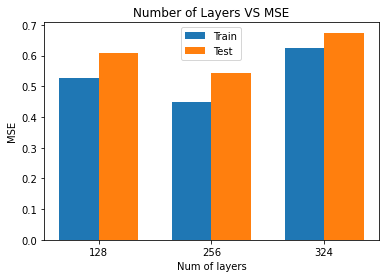

In [24]:
layer_tuner.visualize("Number of Layers VS MSE", "Num of layers")

In [25]:
del layer_tuner

Tune batch size

In [14]:
batch_tuner = ModelTuner(params=[{'batch_size': 32},
                                 {'batch_size': 64},
                                 {'batch_size': 128}
                                ])
batch_tuner.fit_scores(X_train, y_train, X_test, y_test)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=   8.8s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   0.9s
Epoch 1/15
3750/3750 [==============================] - 15s 4ms/step - loss: 1.9135 - mean_squared_error: 1.9135
Epoch 2/15
3750/3750 [==============================] - 13s 4ms/step - loss: 0.7511 - mean_squared_error: 0.7511
Epoch 3/15
3750/3750 [==============================] - 13s 3ms/step - loss: 0.7383 - mean_squared_error: 0.7383
Epoch 4/15
3750/3750 [==============================] - 13s 4ms/step - loss: 0.7250 - mean_squared_error: 0.7250
Epoch 5/15
3750/3750 [==============================] - 14s 4ms/step - loss: 0.7451 - mean_squared_error: 0.7451
Epoch 6/15
3750/3750 [==============================] - 13s 4ms/step - loss: 0.7472 - mean_squared_error: 0.7472
Epoch 7/15
3750/3750 [==============================] - 13s 4ms/step - loss: 0.7188 - mean_squared_error: 0.7188
Epoch 8/15
3750/3750 [==============================] - 14s 4ms/ste

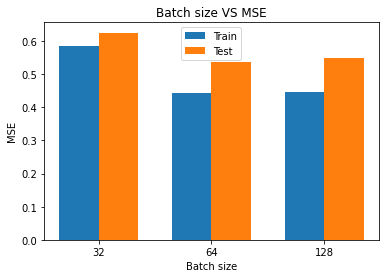

In [15]:
batch_tuner.visualize("Batch size VS MSE", "Batch size")

# Fit the model on partial training data and validate

In [10]:
from sklearn.metrics import mean_squared_error
def model_test(model, X_test, y_test):
  y_pred = model.predict(X_test)
  score = mean_squared_error(y_test, y_pred)
  return score

In [11]:
pipe = create_model(batch_size=64, num_layer=256, init_lr=0.005)

In [12]:
pipe.fit(X_train, y_train)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=   9.1s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   1.9s
Epoch 1/50
1875/1875 [==============================] - 9s 4ms/step - loss: 2.2714 - mean_squared_error: 2.2714
Epoch 2/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6920 - mean_squared_error: 0.6920
Epoch 3/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6621 - mean_squared_error: 0.6621
Epoch 4/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6669 - mean_squared_error: 0.6669
Epoch 5/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6635 - mean_squared_error: 0.6635
Epoch 6/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6308 - mean_squared_error: 0.6308
Epoch 7/50
1875/1875 [==============================] - 7s 4ms/step - loss: 0.6314 - mean_squared_error: 0.6314
Epoch 8/50
1875/1875 [==============================] - 7s 4ms/step - loss

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('price_std',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  ['price']),
                                                 ('summary_count_vec',
                                                  Pipeline(memory=None,
                                                           steps=[('vect',
                                                                   TfidfVectorizer(analyzer='word',
                                                                           

As we can see, the model is still a bit overfitted although we already did feature selection, learning rate decay and hyperparameter tuning.

In [13]:
train_score = model_test(pipe, X_train, y_train)
test_score = model_test(pipe, X_test, y_test)
print(f"Training MSE: {train_score}")
print(f'Testing MSE: {test_score}')

469/469 [==============================] - 2s 3ms/step
Training MSE: 0.3104792462611851
Testing MSE: 0.46910162884452317


# Fit the model on all training data

Train the model using all data with best hyperparameters:
batch_size=64, num_layer=256, init_lr=0.005

In [14]:
pipe = create_model(batch_size=64, num_layer=256, init_lr=0.005)

In [16]:
import numpy as np
pipe.fit(X, y)
predictions = pipe.predict(test_data)
# clip the data between the range of the reviews
predictions = np.clip(predictions, a_min=1.0, a_max=5.0)

[Pipeline] ........ (step 1 of 3) Processing preprocess, total=  11.3s
[Pipeline] .......... (step 2 of 3) Processing to_dense, total=   1.2s
Epoch 1/50
2344/2344 [==============================] - 12s 4ms/step - loss: 2.0779 - mean_squared_error: 2.0779
Epoch 2/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6724 - mean_squared_error: 0.6724
Epoch 3/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6579 - mean_squared_error: 0.6579
Epoch 4/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6694 - mean_squared_error: 0.6694
Epoch 5/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6561 - mean_squared_error: 0.6561
Epoch 6/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6501 - mean_squared_error: 0.6501
Epoch 7/50
2344/2344 [==============================] - 10s 4ms/step - loss: 0.6364 - mean_squared_error: 0.6364
Epoch 8/50
2344/2344 [==============================] - 10s 4ms/ste

In [18]:
score = model_test(pipe, X, y)
print(f"Training MSE: {score}")

2344/2344 [==============================] - 5s 2ms/step
Training MSE: 0.3195194428121786


In [19]:
def export_to_kaggle(rating_pairs_path, predictions, export_path):
  rating_pairs = pd.read_csv(rating_pairs_path)
  rating_pairs['prediction'] = predictions
  rating_pairs.to_csv(export_path, index=False)

In [20]:
export_to_kaggle(rating_pairs_path, predictions, rating_pred_export_path)